# Práctica de calibración de cámaras

Visión por Computador <br>
Practica 2. 2 de noviembre de 2020

Este enunciado está en el archivo "PracticaCalib2020.ipynb" o su versión "pdf" que puedes encontrar en el Aula Virtual.

## Objetivos


Los objetivos de esta práctica son:
* Calibrar una cámara usando el método de calibración de Zhang, implementado en OpenCV.
* Hacer uso de los resultados de la calibración para tomar diferentes medidas en las imágenes.
* Calibrar una cámara a partir de una imagen de una escena en la que se desconoce las coordenadas de sus puntos.

## Requerimientos

Para esta práctica es necesario disponer del siguiente software:
* Python 2.7 ó 3.X 
* Jupyter http://jupyter.org/.
* Las librerías científicas de Python: NumPy, SciPy, y Matplotlib.
* La librería OpenCV.

El material necesario para la práctica se puede descargar del Aula Virtual en la carpeta ``MaterialesPractica``. Esta
carpeta contiene:
* Dos secuencias de imágenes tomadas con un par de cámaras estéreo (izquierda y derecha) en los directorios ``left`` y ``right``.
* Un conjunto de imágenes de alta resolución un edificio, ``building``.

## Condiciones

* La fecha límite de entrega será el lunes 9 de noviembre a las 23:55.
* La entrega consiste en dos archivos con el código, resultados y respuestas a los ejercicios:
  1. Un "notebook" de Jupyter con los resultados. Las respuestas a los ejercicios debes introducirlas en tantas celdas de código o texto como creas necesarias, insertadas inmediatamente después de  un enuciado y antes del siguiente.
  2. Un documento "pdf" generado a partir del fuente de Jupyter, por ejemplo usando el comando ``jupyter nbconvert --execute --to pdf notebook.ipynb``, o simplemente imprimiendo el "notebook" desde el navegador en la opción del menú "File->Print preview". Asegúrate de que el documento "pdf" contiene todos los resultados correctamente ejecutados.
* Esta práctica puede realizarse en parejas.

## 1. Calibración de una cámara

En esta parte se trabajará con la secuencia de imágenes del directorio ``left``. Esta secuencia contiene una serie de imágenes de la plantilla de calibración. Para la calibración se debe tener en cuenta que el tamaño de cada escaque de la plantilla es de 30 mm en las direcciones X e Y.

In [1]:
# uncomment to show results in a window
# %matplotlib tk
import cv2
import glob
import copy
import numpy as np
import scipy.misc as scpm
import matplotlib.pyplot as ppl
import imageio

Implementa la función ``load_images(filenames)`` que reciba una lista de nombres de archivos de imagen
y las cargue como matrices de NumPy. Usa la función ``scipy.misc.imread`` para cargar las imágenes. La función
debe devolver una lista de matrices de NumPy con las imágenes leídas.

In [2]:
def load_images(filenames):
    """Load multiple images."""
    imgs = []
    for route in filenames:
        imgs += [np.array(imageio.imread(route))]
    return imgs

Usa ``load_images`` para cargar todas las imágenes del directorio ``left`` por orden alfabético (la función ``glob.glob`` permite generar la lista de nombres de archivo, y, por ejemplo, la función ``sorted()`` de Python ordena alfabéticamente una lista de cadenas de texto).

In [3]:
imgs = load_images(sorted(glob.glob('left/*.jpg')))

La función ``cv2.findChessboardCorners`` de
OpenCV busca la plantilla de calibración en una imagen y
devuelve una tupla de dos elementos. El primer elemento
es 0 si no consiguió detectar correctamente la plantilla, y
es 1 en caso contrario. El segundo elemento contiene las
coordenadas de las esquinas de la plantilla de calibración,
que sólo son válidas si la detección fue exitosa, es decir, si
el primer elemento de la tupla es 1.

**Ejercicio 1.** Usa la  función ``cv2.findChessboardCorners``, y opcionalmente ``cv2.cornerSubPix``, para detectar automáticamente el patrón de calibración y sus esquinas en todas las imágenes cargadas. El tamaño de la plantilla de calibración en las imágenes
de la práctica es (8, 6) (*columnas x filas*). Almacena los resultados de las múltiples llamadas en
una lista, de modo que el elemento i de dicha lista corresponda al resultado de ``cv2.findChessboardCorners``
para la imagen i cargada anteriormente.


In [4]:
list_corners = []
for i in range(len(imgs)):
    ret, corners = cv2.findChessboardCorners(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2GRAY), (8, 6), None)
    if ret == 1:
        print(f"i={i} -> El algoritmo detectó la plantilla de forma correcta")
        list_corners += [np.array(corners)]
    else:
        print(f"i={i} -> El algoritmo NO detectó la plantilla de forma correcta")
        list_corners += [None]

i=0 -> El algoritmo NO detectó la plantilla de forma correcta
i=1 -> El algoritmo detectó la plantilla de forma correcta
i=2 -> El algoritmo detectó la plantilla de forma correcta
i=3 -> El algoritmo detectó la plantilla de forma correcta
i=4 -> El algoritmo detectó la plantilla de forma correcta
i=5 -> El algoritmo detectó la plantilla de forma correcta
i=6 -> El algoritmo detectó la plantilla de forma correcta
i=7 -> El algoritmo detectó la plantilla de forma correcta
i=8 -> El algoritmo detectó la plantilla de forma correcta
i=9 -> El algoritmo detectó la plantilla de forma correcta
i=10 -> El algoritmo detectó la plantilla de forma correcta
i=11 -> El algoritmo detectó la plantilla de forma correcta
i=12 -> El algoritmo detectó la plantilla de forma correcta
i=13 -> El algoritmo detectó la plantilla de forma correcta
i=14 -> El algoritmo detectó la plantilla de forma correcta
i=15 -> El algoritmo detectó la plantilla de forma correcta
i=16 -> El algoritmo detectó la plantilla de fo

In [5]:
# This section is OPTIONAL
# cornerSubPix is destructive. so we copy standard corners and use the new list to refine
list_corners2 = []
for i in range(len(imgs)):
    if list_corners[i] is None:
        print(f"i={i} -> None corners")
        list_corners2 += [None]
        continue
        
    corners2 = copy.deepcopy(list_corners[i])

    # Refine corner estimation (images mus be in b&w, use cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) to convert from rgb)
    # termination criteria (see, e.g https://docs.opencv.org/3.1.0/dc/dbb/tutorial_py_calibration.html)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    cornersRefined = cv2.cornerSubPix(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2GRAY), corners2, (11, 11), (-1, -1), criteria)
    list_corners2 += [np.array(cornersRefined)]

i=0 -> None corners


El siguiente ejercicio consiste en dibujar sobre las imágenes los puntos detectados por ``cv.FindChessboardCorners``. Por motivos de eficiencia, la función empleada para hacerlo modifica directamente las imagen pasadas por parámetro en lugar de hacer una copia. Para evitar perder las imágenes originales es mejor realizar una copia de las mismas con antelación. Una forma de hacerlo es ``imgs2 = copy.deepcopy(imgs)``
donde ``imgs`` es la lista de imágenes cargadas. Utiliza estas imágenes copiadas en lugar de las
originales en el siguiente ejercicio.

**Ejercicio 2.** Usa ``cv2.drawChessboardCorners`` para dibujar las esquinas detectadas en el ejercicio anterior. Aplícalo a todas las imágenes que fueron correctamente detectadas. Ignora el resto.
Muestra alguna de las imágenes resultantes.

In [6]:
imgs2 = copy.deepcopy(imgs)
for i in range(len(imgs)):
    imgs2[i] = cv2.drawChessboardCorners(imgs2[i], (8, 6), list_corners2[i], list_corners2[i] is not None)

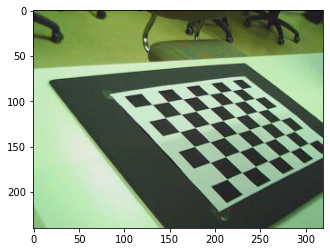

In [7]:
ppl.imshow(imgs2[0])

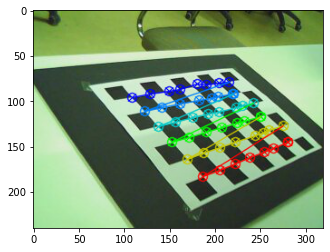

In [8]:
ppl.imshow(imgs2[1])

Para calibrar la cámara, además de las coordenadas de
las esquinas en cada una de las imágenes, se necesitan las
coordenadas tridimensionales de las esquinas en el sistema
de referencia de la escena. Para esta práctica consideraremos que el centro del sistema de referencia, esto es, el
punto de coordenadas $[0, 0, 0]^\top$, es la primera esquina de
la plantilla de calibración detectada en todas las imágenes.
También consideraremos que el eje X corresponde al lado
corto de la plantilla de calibración, y el eje Y al lado largo.
Esta disposición implica que el eje Z apunta en la dirección
normal hacia arriba del plano de calibración.

Para el siguiente ejercicio es muy importante tener en
cuenta que las coordenadas de las esquinas en el sistema de
referencia de la escena deben darse en el mismo orden que
en el que fueron detectadas en cada una de las imágenes.

**Ejercicio 3.** Implementa la función ``get_chessboard_points(chessboard_shape, dx, dy)`` que genere una matriz de NumPy (es decir, un C) de
tamaño $N × 3$ con las coordenadas $(x,y,z)$, resp. (*columna, fila, 0*),  de las esquinas de
la plantilla de calibración en el sistema de referencia de la
escena. $N$ es el número de esquinas de la plantilla.

``chessboard_shape`` es el número de puntos (*columnas, filas*) de la plantilla de calibración. Al igual que
en el Ejercicio 1, debe ser (8, 6). ``dx`` (resp. ``dy``) es el ancho
(resp. alto) de un escaque de la plantilla de calibración.
Para la plantilla utilizada en esta práctica, ambos valores
son 30mm.

In [9]:
def get_chessboard_points(chessboard_shape, dx, dy):
    points = np.zeros((chessboard_shape[0] * chessboard_shape[1], 3), np.float32)
    for i in range(chessboard_shape[1]):
        for j in range(chessboard_shape[0]):
            points[i * chessboard_shape[0] + j][0] = j * dx + 30
            points[i * chessboard_shape[0] + j][1] = i * dy + 30
            
    return points

cb_points = get_chessboard_points((8, 6), 30, 30)
print(cb_points)

[[ 30.  30.   0.]
 [ 60.  30.   0.]
 [ 90.  30.   0.]
 [120.  30.   0.]
 [150.  30.   0.]
 [180.  30.   0.]
 [210.  30.   0.]
 [240.  30.   0.]
 [ 30.  60.   0.]
 [ 60.  60.   0.]
 [ 90.  60.   0.]
 [120.  60.   0.]
 [150.  60.   0.]
 [180.  60.   0.]
 [210.  60.   0.]
 [240.  60.   0.]
 [ 30.  90.   0.]
 [ 60.  90.   0.]
 [ 90.  90.   0.]
 [120.  90.   0.]
 [150.  90.   0.]
 [180.  90.   0.]
 [210.  90.   0.]
 [240.  90.   0.]
 [ 30. 120.   0.]
 [ 60. 120.   0.]
 [ 90. 120.   0.]
 [120. 120.   0.]
 [150. 120.   0.]
 [180. 120.   0.]
 [210. 120.   0.]
 [240. 120.   0.]
 [ 30. 150.   0.]
 [ 60. 150.   0.]
 [ 90. 150.   0.]
 [120. 150.   0.]
 [150. 150.   0.]
 [180. 150.   0.]
 [210. 150.   0.]
 [240. 150.   0.]
 [ 30. 180.   0.]
 [ 60. 180.   0.]
 [ 90. 180.   0.]
 [120. 180.   0.]
 [150. 180.   0.]
 [180. 180.   0.]
 [210. 180.   0.]
 [240. 180.   0.]]


**Ejercicio 4.** Calibra la cámara izquierda usando la lista de resultados de ``cv2.findChessboardCorners``
y el conjunto de puntos del modelo dados por ``get_chessboard_points``, del ejercicio anterior.

In [10]:
# Extract the list of valid images with all corners
valid_corners = []
for i in range(len(list_corners2)):
    if list_corners2[i] is not None and len(list_corners2[i]) == len(cb_points):
        valid_corners += [np.array(np.squeeze(list_corners[i], axis=1))]
num_valid_images = len(valid_corners)

# Prepare input data 
# object_points: numpy array with dimensions (number_of_images, number_of_points, 3)
object_points = [cb_points] * num_valid_images
print(np.shape(object_points))
# image_points: numpy array with dimensions (number_of_images, number_of_points, 2)
image_points = valid_corners
print(np.shape(image_points))

# Calibrate for square pixels corners standard
rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, cv2.cvtColor(imgs[-1], cv2.COLOR_BGR2GRAY).shape[::-1], None, None, flags=cv2.CALIB_FIX_ASPECT_RATIO)

print("Corners standard intrinsics:\n",intrinsics)
print("Corners standerd dist_coefs:", dist_coeffs)
print("rms:", rms)

(18, 48, 3)
(18, 48, 2)
Corners standard intrinsics:
 [[420.32716179   0.         148.65829697]
 [  0.         420.32716179 126.79975753]
 [  0.           0.           1.        ]]
Corners standerd dist_coefs: [[ 1.26333316e-02 -3.17469109e+00  5.18057749e-03 -6.66106835e-03
   1.89232745e+01]]
rms: 0.15266861619981997


###  1.1 Parámetros intrínsecos

Una de las características intrínsecas de una cámara más fácilmente comprensible es su ángulo de visión o campo
de visión (FOV), o el campo de visión de cualquier región en ella. El campo de visión es la amplitud angular de una
determinada escena y se suele expresar en grados. 

**Ejercicio 5.** Conociendo los intrínsecos K y que la región tiene forma rectangular, su esquina superior izquierda está en la posición (10,10) y tiene un tamaño de (50,50) píxeles, calcula el ángulo de visión diagonal que abarca dicha región.


Resuelve en primer lugar el ejercicio analíticamente y, posteriormente, implementa dicha respuesta y calcula un resultado numérico.

**Ejercicio 6.** Calcula cuánto se ha trasladado la cámara entre las imágenes ``left_002.jpg``  y ``left_0014.jpg``.

Resuelve en primer lugar el ejercicio analíticamente y, posteriormente, implementa dicha respuesta y calcula un resultado numérico.

## 2. Par de cámaras estéreo

**Ejercicio 7.** ¿Cuál es la distancia, en milímetros, entre las dos cámaras de par estéreo?

Resuelve en primer lugar el ejercicio analíticamente y, posteriormente, implementa dicha respuesta y calcula un resultado numérico.

Sugerencia: Calibra la cámara derecha usando la secuencia de imágenes del directorio ``right`` y estima dicha distancia.

## 3. Calibración a partir de una imagen

En esta sección vamos a explotar las relaciones de perpendicularidad que suelen aparecer en las escenas urbanas para calibrar la cámara y extraer información sobre dicha escena.

En el directorio ``building`` hay varias imágenes de un edificio que ha sido tomadas con la misma cámara.

**Ejercicio 7.** Se desea estimar la rotación que ha sufrido la cámara entre las imágenes ``build_001`` y ``build_003``.

Resuelve en primer lugar el ejercicio analíticamente y, posteriormente, implementa dicha respuesta y calcula un resultado numérico.

Sugerencia: En primer lugar estudia si es posible estimar los  intrínsecos de la cámara a partir de dichas imágenes y, a continuación, estima la rotación entre ellas.